In [85]:
### importing libraries
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pandas.tools.plotting import parallel_coordinates
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans,SpectralClustering,DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
from sklearn.metrics import silhouette_samples,silhouette_score
%matplotlib inline
warnings.filterwarnings('ignore')

In [86]:
### explore data
df = pd.read_csv('Species_Data.csv')
df.head()

,entrez,symbol,S1,S2,S3,S4,S5,S6,S7,S8,...,S21,S22,S23,S24,S25,S26,S27,S28,S29,S30
0,14679,Gnai3,7.985282,8.654102,7.851483,9.427284,8.484089,8.430295,8.785142,8.234337,...,8.988352,8.861340,8.698631,8.214616,8.933242,8.523217,8.263034,8.442125,8.683792,8.148272
1,54192,Pbsn,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,...,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777
2,12544,Cdc45,5.342660,5.621617,5.894139,5.530200,5.953490,5.800456,5.750067,5.763297,...,5.066617,5.199745,5.207598,5.158604,4.773268,5.028918,5.392552,5.014560,5.372466,5.033642
3,107815,Scml2,4.720995,5.129361,5.017464,5.126493,5.137191,5.081444,4.804693,4.402777,...,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777
4,11818,Apoh,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,...,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777


In [87]:
# clustering operations cannot be performed directly on this data directly,it needs to be processed
df_species = df.drop(['entrez'],axis=1).set_index('symbol').transpose()
df_species.head()

symbol,Gnai3,Pbsn,Cdc45,Scml2,Apoh,Narf,Cav2,Klf6,Scmh1,Cox5a,...,Usp39,Pcdha4,Pcdha7,LOC105243855,Gm34240,Pcdhga3,Gm20750,4932431L22Rik,Rhbg,Mat2a
S1,7.985282,4.402777,5.342660,4.720995,4.402777,6.996224,6.746448,11.632144,6.152779,8.335453,...,4.402777,4.402777,4.402777,4.402777,4.402777,4.720995,4.402777,4.402777,4.402777,4.402777
S2,8.654102,4.402777,5.621617,5.129361,4.402777,7.205572,6.653430,11.641439,6.020570,8.370482,...,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777
S3,7.851483,4.402777,5.894139,5.017464,4.402777,6.938888,6.771460,11.077264,6.142056,8.692579,...,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777
S4,9.427284,4.402777,5.530200,5.126493,4.402777,7.057035,7.086915,14.050733,5.961195,8.279990,...,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777
S5,8.484089,4.402777,5.953490,5.137191,4.402777,7.621014,6.869015,13.834583,6.011059,8.713771,...,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777,4.402777


# KMeans

In [88]:
# creating clusters with kmeans
def kmeans(x,clusters):
    km = KMeans(n_clusters=clusters,algorithm='elkan').fit(x)
    return km.labels_,km.cluster_centers_

# visualising clusters after PCA and scaling on data
def plot_clusters_withPCA(clusters,x,labels,cls_center=None):
    pca = PCA(n_components=2)
    x = pca.fit_transform(x)
    colors = ['b','g','r','y','c','k','m',(0.5,0.1,0.3),'0.44']#cm.rainbow(np.linspace(0, 1,clusters))
    for i in range(clusters):
        ds = x[np.where(labels==i)]
        plt.scatter(ds[:,0],ds[:,1],color=colors[i])
    plt.title("{}clusters after PCA".format(clusters))
    plt.show()
    return

# printing similar species
def SimilarSpecies(labels,df):
    symbol = list(df.index)
    for label in set(labels):
        print "group of similar species-{}".format(label)
        for ind in range(30):
            if labels[ind]==label:
                print symbol[ind],
        print 
    return   

### Elbow Method
Elbow method tries to find clustering step or value of k where the cost function decreases abruptly. This produces an "elbow effect" in the graph

In [89]:
# calculates cost function
def CostFunction(clus_centres,x,labels):
    cost = 0.0
    for label,value in zip(labels,x):
        cost = cost + pow(sum(clus_centres[label]-value)**2,0.5)
    return cost/len(x)

# plot graph for testing elbow method
def Cluster_Analysis(x,iterations=15):
    costJ = np.array([0]*(iterations))
    for i in range(1,iterations+1):
        print "wait",i
        labels,clus_centres = kmeans(x,i)
        costJ[i-1] = CostFunction(clus_centres,x,labels)
    plt.figure(figsize=(25,10))
    plt.title("Elbow Method")
    plt.xlabel("number of clusters")
    plt.ylabel("J(Cost Function)")
    plt.plot(range(1,1+iterations),costJ)
    plt.show()
    return

wait 1
wait 2
wait 3
wait 4
wait 5
wait 6
wait 7
wait 8
wait 9
wait 10
wait 11
wait 12
wait 13
wait 14
wait 15


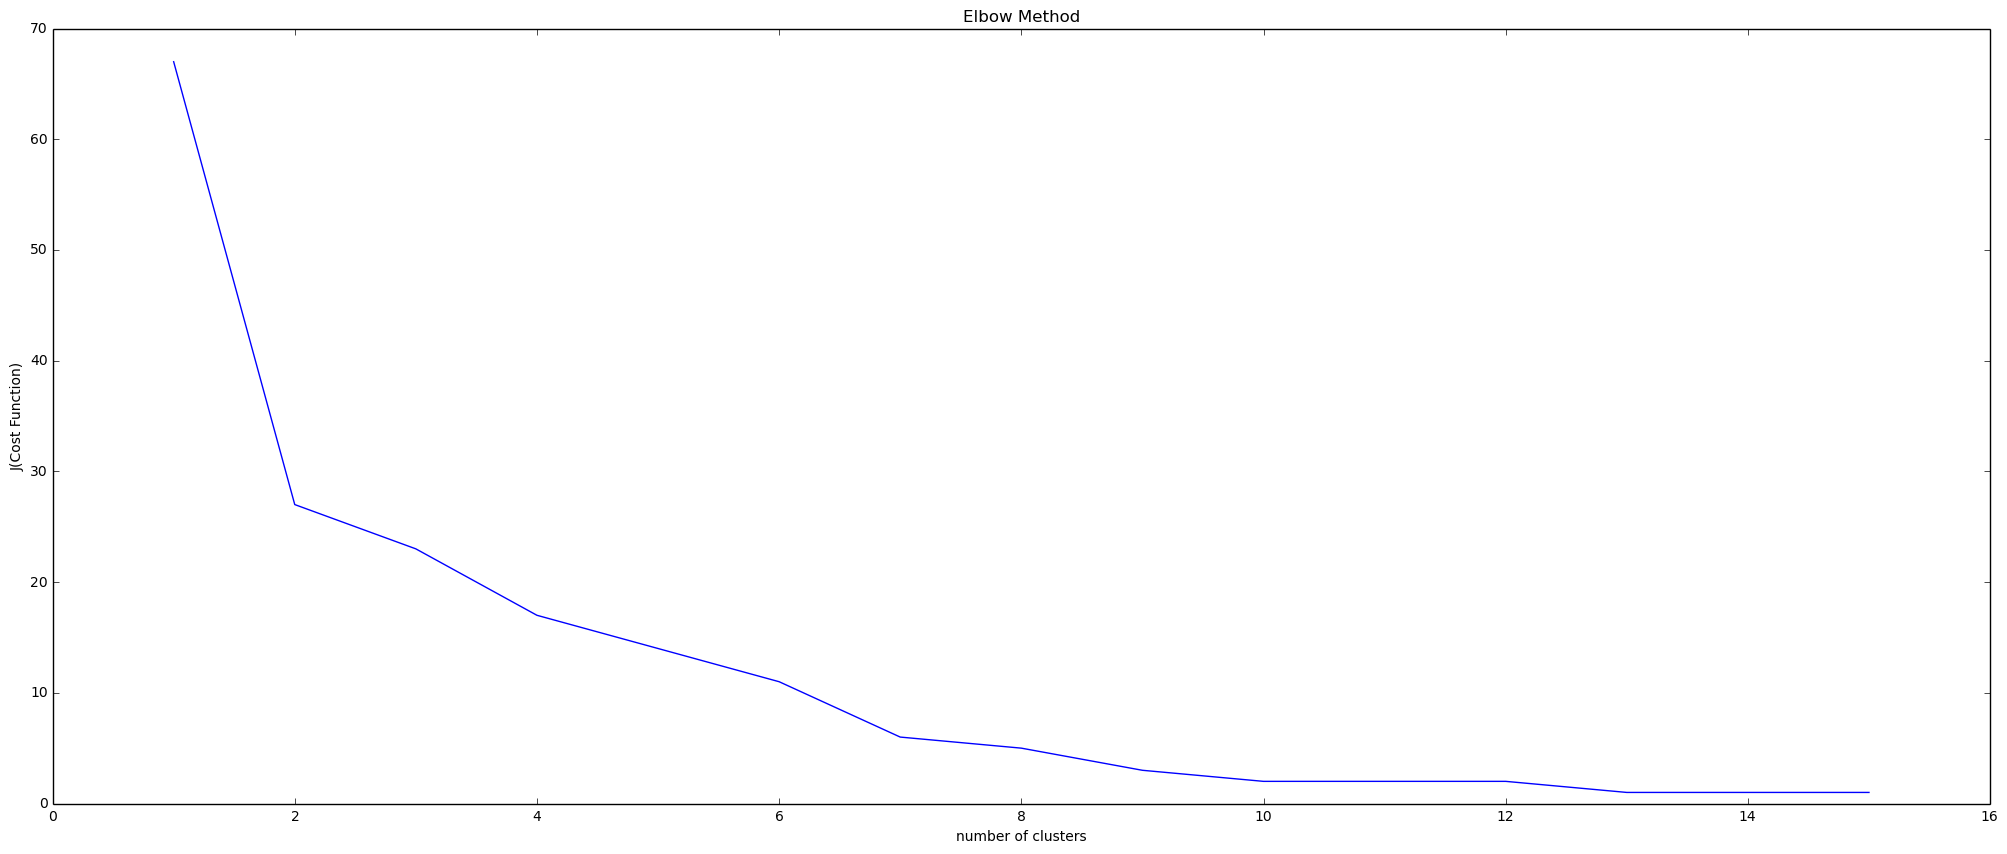

In [90]:
x = df_species.values
pca = PCA(n_components=2)
x = pca.fit_transform(scale(x))
Cluster_Analysis(x,15)

From the above plot of Elbow method it is clear that number of clusters must be 2.But we know that elbow method is 
a heuristic approach of finding clusters,and one cannot depend on it solely and we have to take possible numbers of clusters and performs some other tests to confirm our heuristic.

### Silhouette Test

Now to determine which of these 2,3,4,5,6 would be best to cluster our data into groups naturally.
For that purpose we are going to use Silhouette test.

In [91]:
x = df_species.values
for i in [2,3,4,5,6]:
    labels,clus_centres = kmeans(x,i)
    print silhouette_score(x,labels)

0.326451114456
0.286529039486
0.217330864677
0.258458407208
0.260694070562


For running multiple times we found tha silhoutte score for 2 is always positive and largest among all,
this gives us a proof that among 2,3,4,5,6 only 2 is providing a natural cluster for our dataset.

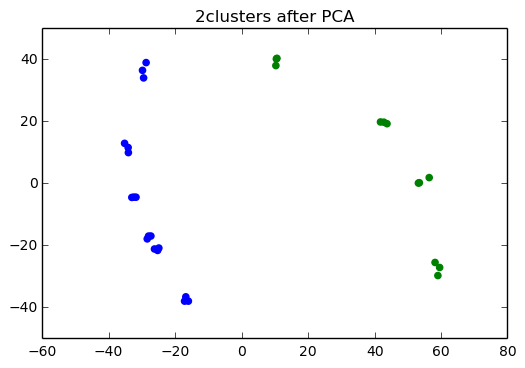

In [92]:
# ploting clusters after PCA 
x = df_species.values
labels,clus_centres = kmeans(x,2)
plot_clusters_withPCA(2,x,labels)

# TSNE(t-distributed stochastic neighbor embedding)
The technique has become widespread in the field of machine learning,as it can from data with hundreds or even thousands of dimensions it can convert into two-dimensonal.

In [93]:
# visualising clusters after using TSNE and scaling on data
def plot_clusters_withTSNE(clusters,x,labels,cls_center=None):
    x = TSNE(learning_rate=100).fit_transform(x)
    colors = ['b','g','r','y','c','k','m',(0.5,0.1,0.3),'0.44']#cm.rainbow(np.linspace(0, 1,clusters))
    for i in range(clusters):
        ds = x[np.where(labels==i)]
        plt.scatter(ds[:,0],ds[:,1],color=colors[i])
    plt.title("{}clusters after TSNE".format(clusters))
    plt.show()
    return 

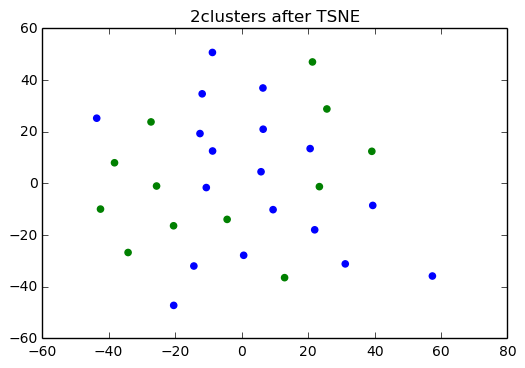

In [94]:
plot_clusters_withTSNE(2,x,labels,)

### Similarity by KMeans clustering

In [95]:
SimilarSpecies(labels,df_species)## printing clusters members/ similar species according kmeans

group of similar species-0
S13 S14 S15 S16 S17 S18 S19 S20 S21 S22 S23 S24 S25 S26 S27 S28 S29 S30
group of similar species-1
S1 S2 S3 S4 S5 S6 S7 S8 S9 S10 S11 S12


# Hiearchical Clustering Dendrogram
In Hiearchical Clustering Dendogram,we starts from each data points as singleton clusters,in each iteration we calculate the distance between two clusters (aka data points initially) and combine clusters in each successive layer having distance within cutoff decided by metric and method used.

### Linkage Matrix
Scipy's linkage function return Linkage matrix.Linkage matrix contains steps of each clusters formed by Hiearchical
Clustering Dendrogram.

In [96]:
#### generates linkage matrix "Z"
x = scale(df_species.values)
# pca = PCA(n_components=2)
# x = pca.fit_transform(scale(x))
Z = linkage(x, 'ward')

### Dendrogram
A dendrogram is a visualization in form of a tree showing the order and distances of merges during the hierarchical clustering.A dendrogram is made up of many U-shaped lines connecting data in a hiearchical tree, where height of each U represents the distance where two clusters are merged.

In [97]:
def plot_dendrogram(Z,max_d=None):
#     plt.figure(figsize=(25,10))
    plt.title('Hiearchical Clustering Dendrogram')
    plt.xlabel('species')
    plt.ylabel('distances')
    dendrogram(
        Z,
        leaf_rotation = 90,
        leaf_font_size = 12,
    )
    if max_d!=None:
        plt.axhline(y=max_d, c='k')
    plt.show()
    return

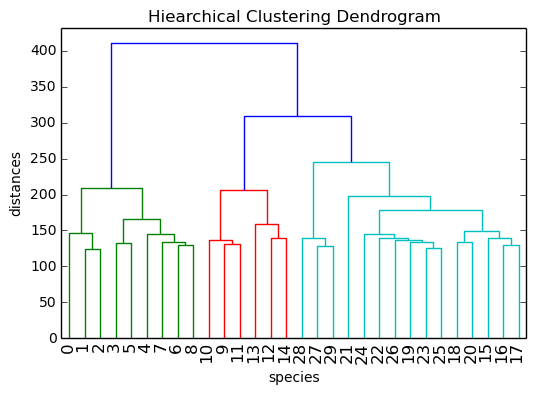

In [98]:
# plot dendrogram
plot_dendrogram(Z)

By looking at the dendrogram,we can say that a total of 7 clusters are there.And
180 seems to be good fit for maximum distance above which no merging of clusters takes place.

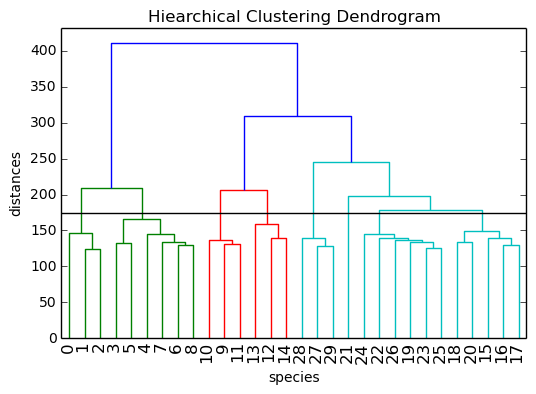

In [99]:
# plot dendrogram with max_d=180
plot_dendrogram(Z,175)

### FCluster
Scipy's fcluster function creates flat clusters from the hierarchical clustering with help of linkage matrix 'Z' defined earlier.It accepts maximun distance for cluster merging and create clusters therefore.

In [100]:
# finding labels for each data points
max_d = 175
labels = fcluster(Z,max_d,criterion='distance')

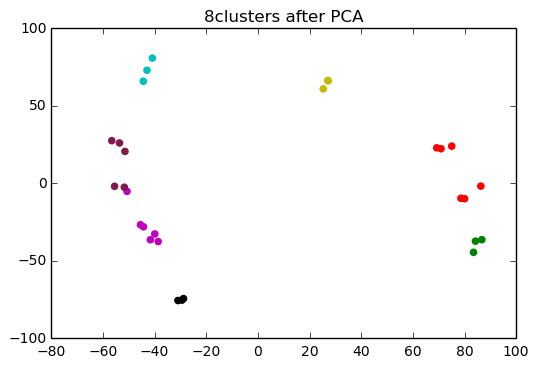

In [101]:
# plotting clusters after processing it with PCA to 2-D
# plt.figure(figsize=(25,10))
plot_clusters_withPCA(8,x,labels)
plt.show()

### similarity by Hiearchical Clustering

In [102]:
# printing similar species
def SimilarSpecies(labels,df):
    symbol = list(df.index)
    for label in set(labels):
        print "group of similar species-{}".format(label)
        for ind in range(30):
            if labels[ind]==label:
                print symbol[ind],
        print 
    return
SimilarSpecies(labels,df_species)

group of similar species-1
S1 S2 S3
group of similar species-2
S4 S5 S6 S7 S8 S9
group of similar species-3
S10 S11 S12
group of similar species-4
S13 S14 S15
group of similar species-5
S28 S29 S30
group of similar species-6
S20 S23 S24 S25 S26 S27
group of similar species-7
S16 S17 S18 S19 S21
group of similar species-8
S22


# Summary
Reasons why i preferred Hiearchical Clustering over Kmeans Clustering for our dataset are described below.

##### About KMeans Clustering

**A major problem with KMeans clustering while dealing with high dimensional data is using euclidean distance**
Since multiple dimension as in our case are hard to think in,impossible to visualise due to the exponential growth of the number with each dimesion.Thus the concept of distance become less precise or invaluable as the number of dimension increases.Because when number of dimensions reachs infinity distance between any two points converges meaning the maximum and minimum distance between any two points in the dataset remains the same.This condition is known as ** Curse Of Dimensionality **.***If we still want to use KMeans we can change the distance metric with cosine matrics,instead we can also use hiearchical clustering***

** KMeans is extremely sensitive to cluster centre initialisation **.Since bad cluster initialisation can lead to poor convergence,bad overall clustering,could struck into local optima.

** KMeans can struck in local optima.**In our when we use Elbow method to find numbers of clusters for KMeans clustering, we can clearly see from the plot that at number 2 the decrement in cost function was maximum.And this was supported by silhouette test ****(here both elbow method and silhoutte used euclidean distance metric)****.

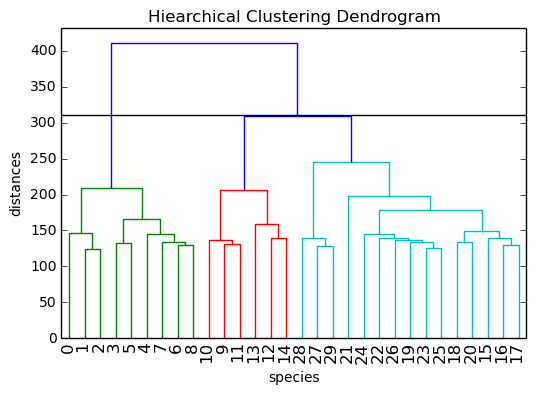

In [103]:
plot_dendrogram(Z,310)

Our KMeans find this value of max_id>300 and struck into local optima instead of finding global optima, thus predicting number of clusters to be 2.

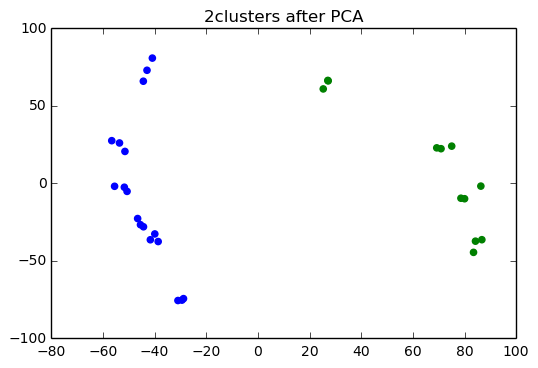

In [106]:
labels,clus_centres = kmeans(x,2)
plot_clusters_withPCA(2,x,labels)

***Here we can clearly see that our kmeans only creates clusters with distance greater than 300 and got struck into local optima,with creating only two  big clusters one on each side of the plot.***Though it sheerly ignores other small clusters(identified later) within those two big clusters.SO it is clear we can't really depend on kmeans or elbow method blindly when we donot know much about our dataset i.e. in datatset having dimension of several thousands.

#### About Hiearchical Clustering

I preferred Hiearchical Clustering as *** it doesnot need the number of clusters as input, partitions can be visualised using a tree structure called dendrogram***

**It is slow but doesnot struck into local optima and always reach global optima as we can view partitions as different level of merging and can visually select the value of clusters that was naturally present in the dataset**